# TD Fast API

In [ ]:
!pip install mlflow fastapi uvicorn


In [ ]:
import mlflow

mlflow.set_tracking_uri("http://89.58.44.97:5000/")

In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mlflow.set_experiment("iris_classification")

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

with mlflow.start_run():
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)

    mlflow.log_metric("accuracy", acc)

    signature = infer_signature(X_train, model.predict(X_train))
    input_example = X_train[:5]

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        signature=signature,
        input_example=input_example,
        registered_model_name="iris_rf_model"
    )


#### 1. Créer une fonction qui permet de récupérer un modèle depuis MLFlow

In [ ]:
model_name = "iris_rf_model"
stage = "latest"

MODEL_URI = f"models:/{model_name}/{stage}"

model = None

def load_model():
    global model
    if model is None:
        model = mlflow.pyfunc.load_model(MODEL_URI)
    return model

In [ ]:
model = load_model()

# 2. Créer un modèle Pydantic pour consolider le modèle de données



Source: https://docs.pydantic.dev/

In [ ]:
from pydantic import BaseModel, Field

class IrisRequest(BaseModel):
    sepal_length: float = Field(gt=0)
    sepal_width: float = Field(gt=0)
    petal_length: float = Field(gt=0)
    petal_width: float = Field(gt=0)


# 3. Créer notre première route API


In [ ]:
from fastapi import FastAPI

app = FastAPI()
model = load_model()

@app.post("/predict")
def predict(data):
    features = [[
            data.sepal_length,
            data.sepal_width,
            data.petal_length,
            data.petal_width,
        ]]
    pred = int(model.predict(np.array(features))[0])
    return {"prediction": pred}


In [ ]:
!uvicorn main:app --host 0.0.0.0 --port 8000 --reload


# 3. Faite une inférence du modèle avec `curl` ou en `python`

In [ ]:
curl -X POST http://localhost/predict \
  -H "Content-Type: application/json" \
  -d '{
    "sepal_length": 5.1,
    "sepal_width": 3.5,
    "petal_length": 1.4,
    "petal_width": 0.2
  }'


In [ ]:
import requests
url = "http://localhost:8000"
data = {"sepal_length": 5.1,"sepal_width": 3.5,"petal_length": 1.4,"petal_width": 0.2}

req = requests.post(url=f"{url}/predict", json=data)
print(req.json())

# 4. Utiliser le Swagger de FastAPI

Swagger UI est une bibliothèque open-source qui permet de visualiser et de tester facilement une API RESTful en fournissant une interface graphique interactive.

- Documentation automatique de l'API : Swagger UI permet de générer automatiquement une documentation complète et précise de votre API, en exposant tous les endpoints, les paramètres requis, les types de données acceptés, etc. Cela permet aux utilisateurs de comprendre rapidement et facilement comment utiliser votre API.

- Tester facilement l'API : Swagger UI fournit une interface graphique interactive pour tester les endpoints de votre API, sans avoir à écrire de code supplémentaire ou à utiliser des outils tiers. Cela facilite grandement le processus de débogage et d'assurance qualité de votre API.

- Gestion des erreurs : Swagger UI affiche automatiquement les erreurs générées par votre API, ce qui facilite la résolution de problèmes et améliore l'expérience utilisateur.

http://localhost:8000/docs

#5. Gérer les tâches longues avec un mécanisme asynchrone

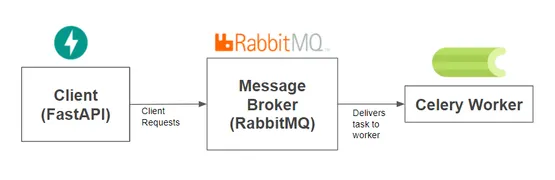

Lancer un système de message queue:
```
docker run -p 6379:6379 redis
```

On souhaite désormais ajouter une route asynchrone pour le traitement des requêtes en batch


Ajouter une tâche

In [ ]:
from celery import Celery

celery = Celery(
    "iris_tasks",
    broker="redis://redis:6379/0",
    backend="redis://redis:6379/0",
)

celery.conf.update(
    task_serializer="json",
    accept_content=["json"],
    result_serializer="json",
    timezone="UTC",
    enable_utc=True,
)


Ajouter le code de la tâche asynchrone

In [ ]:
import numpy as np
from celery_app import celery
from app.load_model import load_model

model = load_model()

@celery.task(name="predict_batch_task")
def predict_batch_task(batch):
    features = [
        [
            item["sepal_length"],
            item["sepal_width"],
            item["petal_length"],
            item["petal_width"],
        ]
        for item in batch
    ]

    preds = model.predict(np.array(features))
    return [int(p) for p in preds]


Ajouter la route asynchone dans l'API

In [ ]:
@app.post("/predict_batch")
async def predict_batch(data: IrisInputs):
    task = predict_batch_task.delay([item.model_dump() for item in data])
    return {"task_id": task.id}


@app.get("/predict_batch/{task_id}")
async def get_batch_result(task_id: str):
    task = AsyncResult(task_id, app=celery)

    if task.state == "PENDING":
        return {"status": "pending"}

    if task.state == "FAILURE":
        raise HTTPException(status_code=500, detail=str(task.result))

    if task.state == "SUCCESS":
        return {"status": "done", "predictions": task.result}
    return {"status": task.state}


Lancer le worker
```
docker run -p 6379:6379 redis
celery -A celery_app.celery worker --loglevel=info
uvicorn main:app --reload
```

# 6. Test de charge avec **Locust**

Lancez le docker compose `docker-compose.yaml` et rendez vous sur http://localhost:8089